<a href="https://colab.research.google.com/github/Rmm6699/HW/blob/master/W1_TA_xgb_lgb_cab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Goal

## What're we doing?
We're going to let XGBoost, LightGBM and Catboost battle it out in 3 rounds:

- **Classification:** Classify images in the Fashion MNIST (60,000 rows, 784 features)

- **Regression:** Predict NYC Taxi fares (60,000 rows, 7 features)

- **Massive Dataset:** Predict NYC Taxi fares (2 million rows, 7 features)


## How're we doing it?
In each round here are the steps we'll follow:
1. Train baseline models of XGBoost, Catboost, LightGBM (trained using the same paramaters for each model)
2. Train fine-tuned models of XGBoost, Catboost, LightGBM using GridSearchCV
3. Measure performance on the following metrics:
    - training and prediction times
    - prediction score
    - interpretability (feature importance, shap values, visualize trees)

# Setup

In [ ]:
# Essentials
import numpy as np
import pandas as pd
import random
import time
import gc
import os
from datetime import datetime

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
import seaborn as sns
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 80,60

# Models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm.plotting import plot_importance
import lightgbm
import xgboost as xgb
import catboost
from xgboost import plot_tree

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from dateutil import tz
from geopy import distance
import shap

pd.set_option('display.max_columns', None)

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

print(os.listdir("./data/"))

['fashionmnist', 'nyctaxi']


<Figure size 1600x800 with 0 Axes>

In [ ]:
def show_time(diff):
    m, s = divmod(diff, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    print("Execution Time: " + "{0:02d}:{1:02d}:{2:02d}".format(h, m, s))

In [ ]:
# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def Train(clf, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    model = clf.fit(X,y)
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('\nPrediction time: ')
    show_time(end - start)
    return model

# Takes in a classifier, calculates the training + prediction times and accuracy score, returns a model
def GridSearch(clf, params, X, y, X_predict, y_predict, type='classification'):
    # Train
    start = time.time()
    if(type=='classification'):
        model = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    else:
        model = GridSearchCV(clf, params, scoring='r2', n_jobs=-1, cv=5).fit(X,y).best_estimator_
    end = time.time()
    print('Training time: ')
    show_time(end - start)
    training_times.append(end - start)

    # Predict
    start = time.time()
    if(type=='classification'):
        scores.append(accuracy_score(y_predict, model.predict(X_predict)))
    else:
        scores.append(rmse(y_test, model.predict(X_test)))
    end = time.time()
    prediction_times.append(end - start)
    print('Prediction time: ')
    show_time(end - start)
    return model

In [ ]:
# Takes in model scores and plots them on a bar graph
def plot_metric(model_scores, score='Accuracy'):
    # Set figure size
    rcParams['figure.figsize'] = 7, 5
    plt.bar(model_scores['Model'], height = model_scores[score])
    xlocs, xlabs = plt.xticks()
    xlocs = [i for i in range(0,6)]
    xlabs = [i for i in range(0,6)]
    if(score != 'Prediction Times'):
        for i, v in enumerate(model_scores[score]):
            plt.text(xlocs[i] - 0.25, v + 0.01, str(v))
    plt.xlabel('Model')
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Takes in training data and a model, and plots a bar graph of the model's feature importances
def feature_importances(df, model, model_name, max_num_features=10):
    feature_importances = pd.DataFrame(columns = ['feature', 'importance'])
    feature_importances['feature'] = df.columns
    feature_importances['importance'] = model.feature_importances_
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances = feature_importances[:max_num_features]
    # print(feature_importances)
    plt.figure(figsize=(12, 6));
    sns.barplot(x="importance", y="feature", data=feature_importances);
    plt.title(model_name+' features importance:');

# Takes in training data and a model, and plots a bar graph of SHAP values
def shap_values(df, model, model_name):
    shap_values = shap.TreeExplainer(model).shap_values(df)
    shap_values[:5]
    shap.summary_plot(shap_values, df.iloc[:1000,:])

# Round 1: Classification: Classify images in the Fashion MNIST

## A. Explore the Fashion MNIST dataset (60000 rows, 784 features)

## Feature
pixel1 ~pixel784 - Each value is the darkness of the pixel (1 to 255, 28*28 image)

## Target
label :
- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

In [ ]:
# Read in dataset
fetch_from = './data/fashionmnist/fashion-mnist_train.csv'
train = pd.read_csv(fetch_from)

fetch_from = './data/fashionmnist/fashion-mnist_test.csv'
test = pd.read_csv(fetch_from)

train.head(1)

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   

   pixel9  pixel10  pixel11  pixel12  pixel13  pixel14  pixel15  pixel16  \
0       0        0        0        0        0        0        0        0   

   pixel17  pixel18  pixel19  pixel20  pixel21  pixel22  pixel23  pixel24  \
0        0        0        0        0        0        0        0        0   

   pixel25  pixel26  pixel27  pixel28  pixel29  pixel30  pixel31  pixel32  \
0        0        0        0        0        0        0        0        0   

   pixel33  pixel34  pixel35  pixel36  pixel37  pixel38  pixel39  pixel40  \
0        0        0        0        0        0        0        0        0   

   pixel41  pixel42  pixel43  pixel44  pixel45  pixel46  pixel47  pixel48  \
0        0        0        0        0        0        0        0        0   

   pixel49  pixel50  pixel51  pixel52  pixel53  pixel54  pixel55  pixel56  \
0        0        0        0        0        0        0        0        0   

   pixel57  pixel58  pixel59  pixel60  pixel61  pixel62  pixel63  pixel64  \
0        0        0        0        0        0        0        0        0   

   pixel65  pixel66  pixel67  pixel68  pixel69  pixel70  pixel71  pixel72  \
0        0        0        0        0        0        0        0        0   

   pixel73  pixel74  pixel75  pixel76  pixel77  pixel78  pixel79  pixel80  \
0        0        0        0        0        0        0        0        0   

   pixel81  pixel82  pixel83  pixel84  pixel85  pixel86  pixel87  pixel88  \
0        0        0        0        0        0        0        0        0   

   pixel89  pixel90  pixel91  pixel92  pixel93  pixel94  pixel95  pixel96  \
0        4        0        0        0        0        0       62       61   

   pixel97  pixel98  pixel99  pixel100  pixel101  pixel102  pixel103  \
0       21       29       23        51       136        61         0   

   pixel104  pixel105  pixel106  pixel107  pixel108  pixel109  pixel110  \
0         0         0         0         0         0         0         0   

   pixel111  pixel112  pixel113  pixel114  pixel115  pixel116  pixel117  \
0         0         0         0         0         0         0         0   

   pixel118  pixel119  pixel120  pixel121  pixel122  pixel123  pixel124  \
0         0         0        88       201       228       225       255   

   pixel125  pixel126  pixel127  pixel128  pixel129  pixel130  pixel131  \
0       115        62       137       255       235       222       255   

   pixel132  pixel133  pixel134  pixel135  pixel136  pixel137  pixel138  \
0       135         0         0         0         0         0         0   

   pixel139  pixel140  pixel141  pixel142  pixel143  pixel144  pixel145  \
0         0         0         0         0         0         0         0   

   pixel146  pixel147  pixel148  pixel149  pixel150  pixel151  pixel152  \
0        47       252       234       238       224       215       215   

   pixel153  pixel154  pixel155  pixel156  pixel157  pixel158  pixel159  \
0       229       108       180       207       214       224       231   

   pixel160  pixel161  pixel162  pixel163  pixel164  pixel165  pixel166  \
0       249       254        45         0         0         0         0   

   pixel167  pixel168  pixel169  pixel170  pixel171  pixel172  pixel173  \
0         0         0         0         0         1         0         0   

   pixel174  pixel175  pixel176  pixel177  pixel178  pixel179  pixel180  \
0       214       222       210       213       224       225       217   

   pixel181  pixel182  pixel183  pixel184  pixel185  pixel186  pixel187  \
0       220       254       233       219       221       217       223   

   pixel188  pixel189  pixel190  pixel191  pixel192  pixel193  pixel194  \
0       221       240       254         0         0         1         0   

   pixel195  pixel196  pixel197  pixel1

In [ ]:
# Perform train-test split
X_train, y_train, X_test, y_test = train.iloc[:,1:], train['label'], test.iloc[:,1:], test['label']
X_train.shape, X_test.shape
# Each image is 28*28(=784) pixels, hence the 784 features

((60000, 784), (10000, 784))

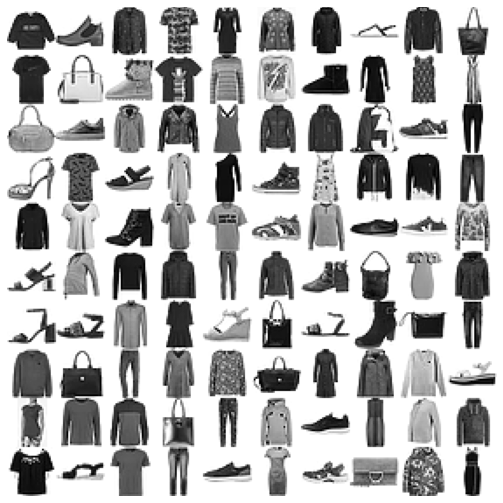

In [ ]:
# Sample some images in the dataset
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(9,9))
example_images = X_train[:100]
plot_digits(example_images.values, images_per_row=10)
plt.show()

## B. Baseline models

In [ ]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

### XGBoost

In [ ]:
xgboost = Train(XGBClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)

[08:46:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 
Execution Time: 00:01:42

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [ ]:
lgb = Train(LGBMClassifier(n_estimators=50, max_depth=5), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:00:22

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [ ]:
cat = Train(CatBoostClassifier(n_estimators=50, verbose=False, max_depth=6), X_train, y_train, X_test, y_test)

Training time: 
Execution Time: 00:01:18

Prediction time: 
Execution Time: 00:00:00


## C. Fine-tuned models

### XGBoost

In [ ]:
# XGBoost with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
xgboost_gs = GridSearch(XGBClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

[09:01:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training time: 
Execution Time: 00:11:24
Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [ ]:
# LightGBM with GridSearch
param_grid=[{'max_depth':[5,10],
           'n_estimators':[100],
           'learning_rate':[0.05,0.1],
           'colsample_bytree':[0.8,0.95]}]
lgb_gs = GridSearch(LGBMClassifier(random_state=42), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:06:37
Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [ ]:
# CatBoost with GridSearch
start = time.time()
param_grid=[{'n_estimators':[10,100],
            'learning_rate':[0.05,0.1],
            'rsm':[0.5,0.8]}]
cat_gs = GridSearch(CatBoostClassifier(random_state=42, silent = True,
                        bootstrap_type = 'Bernoulli'), param_grid, X_train[:4000], y_train[:4000], X_test, y_test)

Training time: 
Execution Time: 00:10:37
Prediction time: 
Execution Time: 00:00:00


## D. The Results

In [ ]:
# free up memory be deleting dataframes no longer needed
del [[y_train, X_test, y_test, train, test]]

In [ ]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat),
         ('XGBoost GridSearch', xgboost_gs),
         ('LightGBM GridSearch', lgb_gs),
         ('CatBoost GridSearch', cat_gs)]

### Accuracy Scores

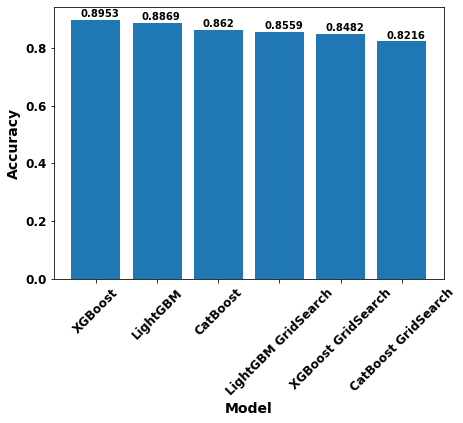

In [ ]:
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'Accuracy': scores })
model_scores.sort_values(by='Accuracy', ascending=False, inplace=True)
plot_metric(model_scores, score='Accuracy')

### Training and Prediction Times

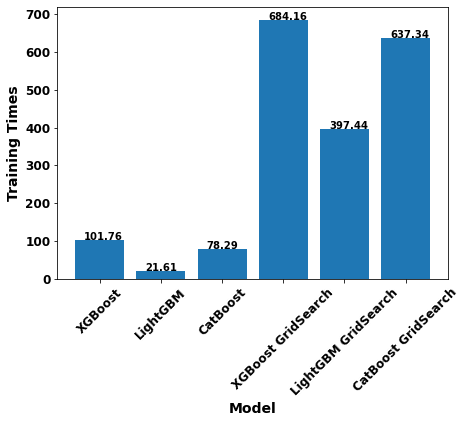

In [ ]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

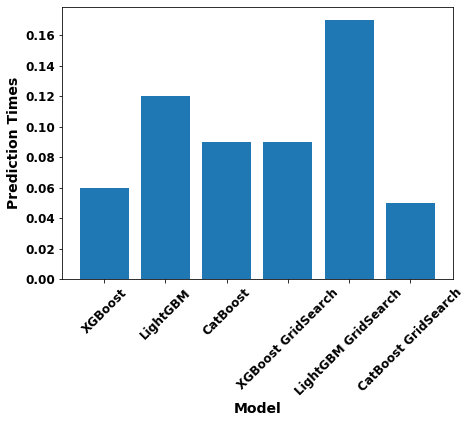

In [ ]:
prediction_times = [round(time,2) for time in prediction_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Interpretability

A model's prediction score only paints a partial picture of its predictions. We also want to know *why* the model is making its predictions.

Here we plot the model's feature importances, SHAP values and draw an actual decision tree to get a firmer understanding of the model's predictions.

#### Feature Importances

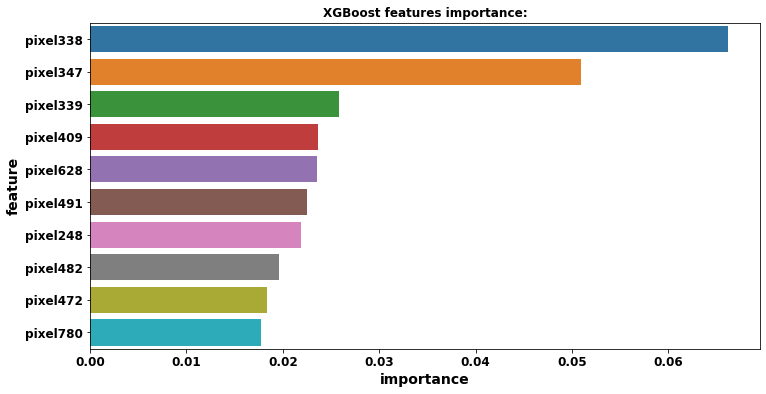

In [ ]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

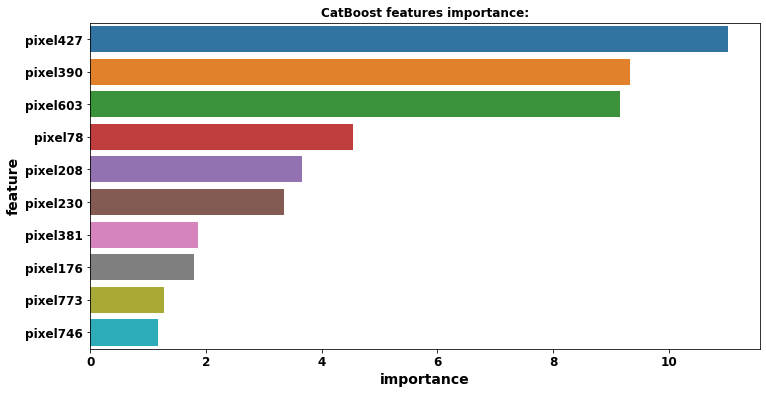

In [ ]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

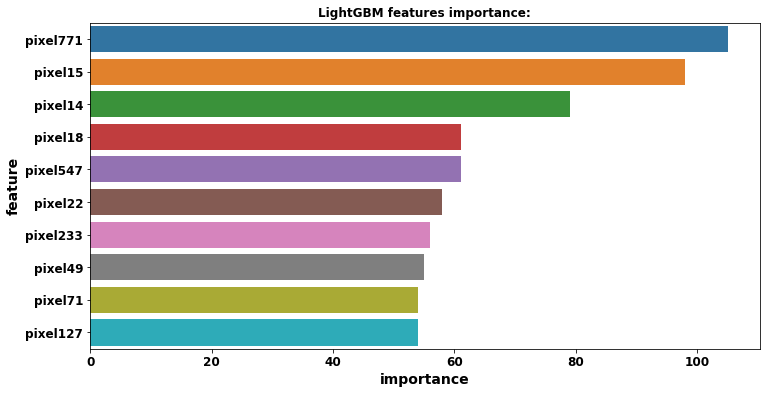

In [ ]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

Reference table for understanding which class names the class indexes refer to in the graphs below:

| Class | Name |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

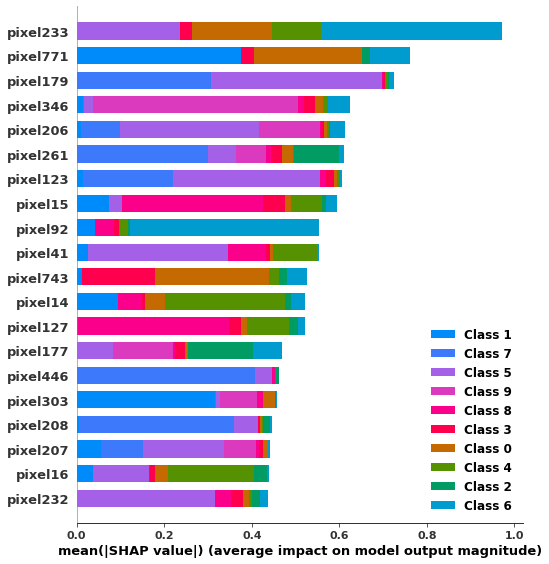

In [ ]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

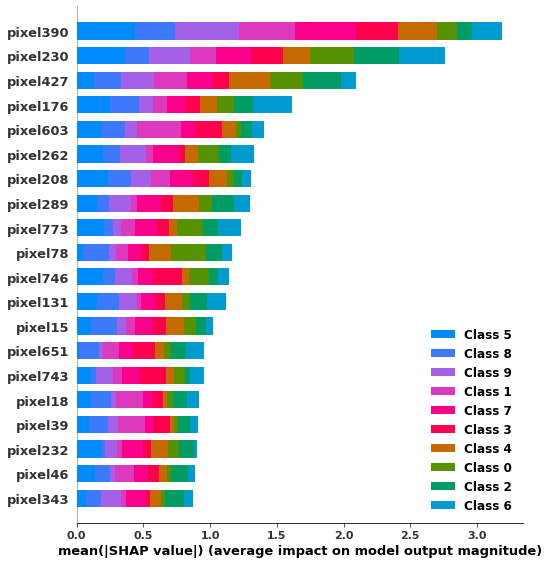

In [ ]:
# CatBoost
shap_values(X_train.iloc[:500,:], cat, 'CatBoost')

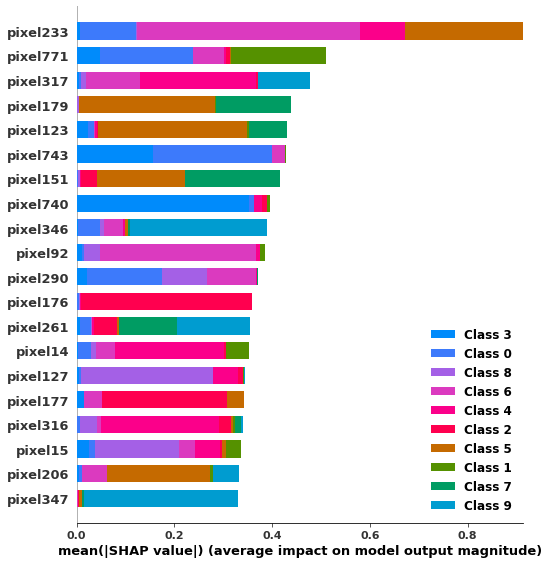

In [ ]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

#### Visualize Trees

In [ ]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

<AxesSubplot:>

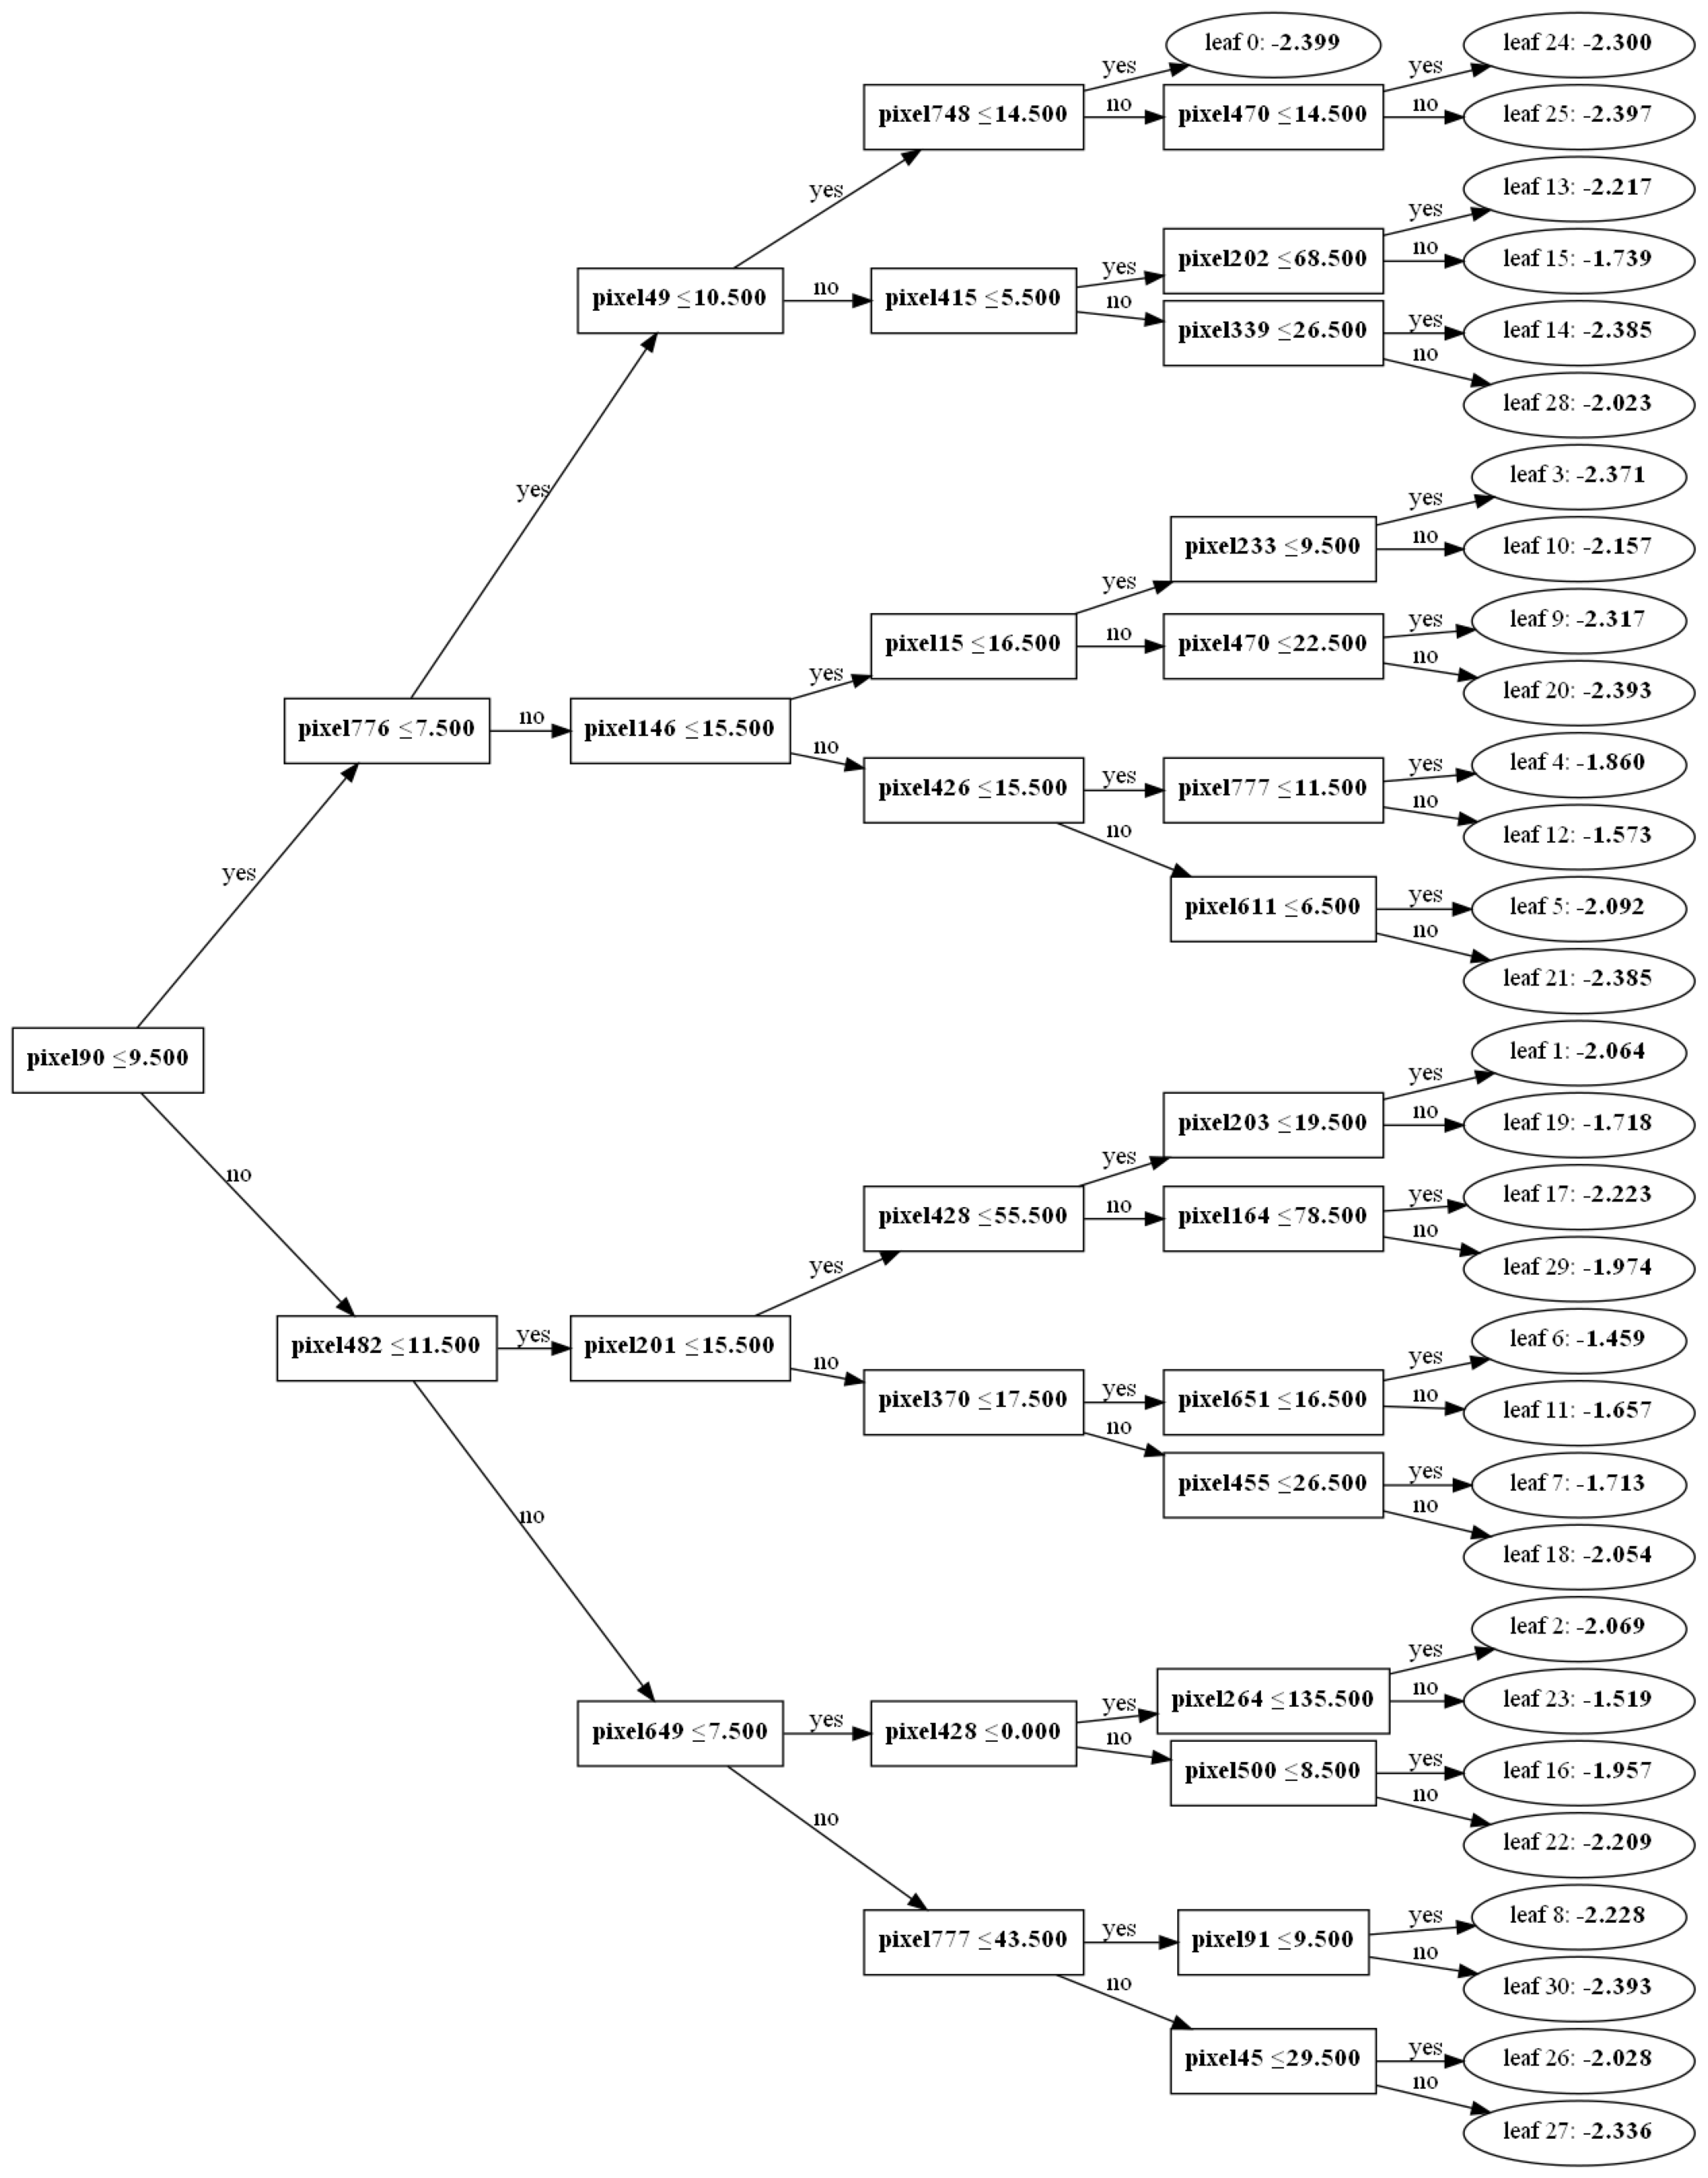

In [ ]:
# LightGBM
lightgbm.plot_tree(lgb)

<AxesSubplot:>

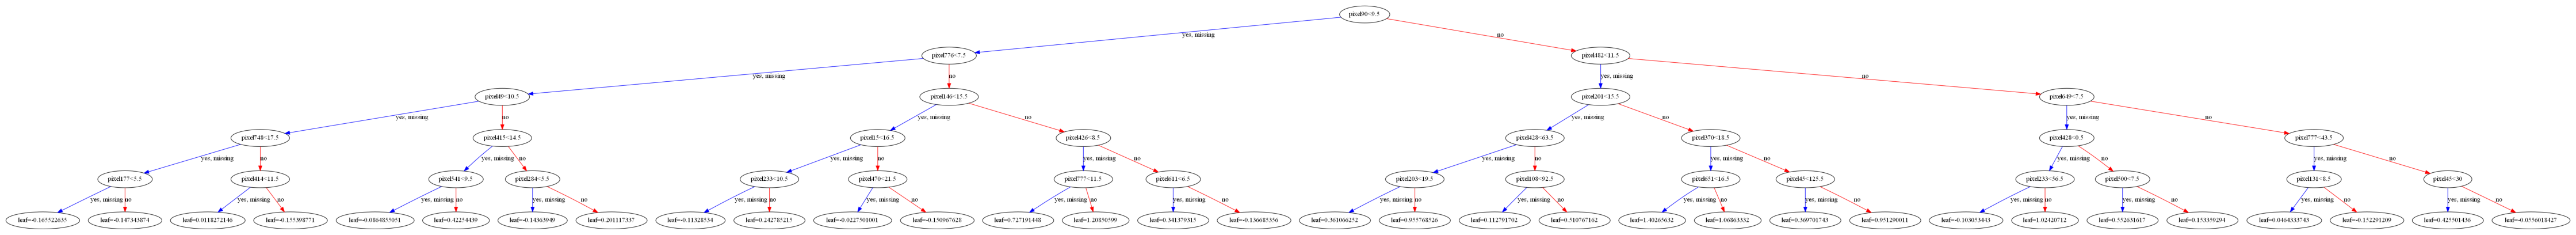

In [ ]:
# XGBoost
xgb.plot_tree(xgboost)

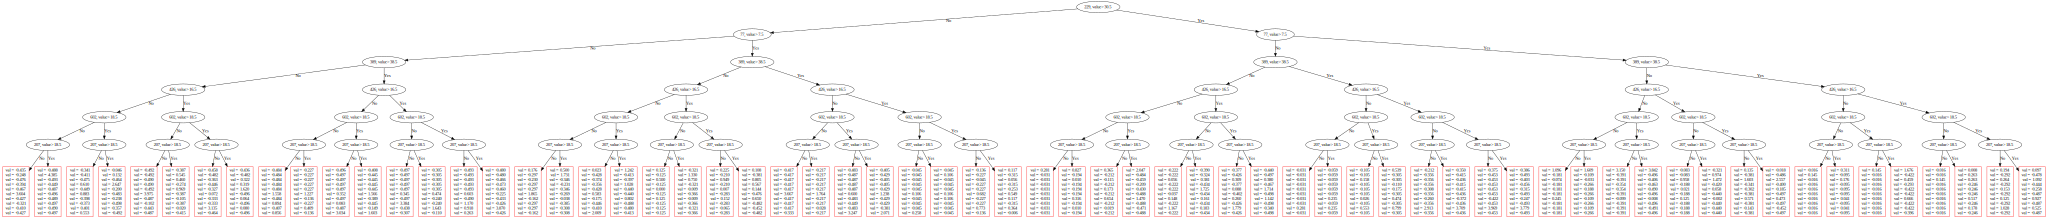

In [ ]:
cat.plot_tree(0)

In [ ]:
# Clear memory before moving onto the next round
import gc
gc.collect()

16251

In [ ]:
del [[X_train]]

# Round 2: Regression on a medium Dataset: Predict NYC Taxi fares

## A. Explore the NYC Taxi dataset (60,000 rows, 6 features)
### Feature
- pickup_datetime - timestamp，表示計程車載客的起始時間。

- pickup_longitude - float，計程車載客起始位置的經度坐標。

- pickup_latitude - float，計程車載客起始位置的緯度坐標。

- dropoff_longitude - float，計程車載客結束位置的經度坐標。

- dropoff_latitude - float，計程車載客結束位置的緯度坐標。

- passenger_count - integer，表示乘坐計程車的乘客人數。

### Target
- fare_amount - float，計程車費用(美元)。

In [ ]:
# Get data from New York City Taxi Fare Prediction
train = pd.read_csv('./data/nyctaxi/train_small.csv')
test = pd.read_csv('./data/nyctaxi/test_small.csv')
train.head(5)

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3          7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4          5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2  
3         -73.991567         40.758092                1  
4         -73.956655         40.783762                1

In [ ]:
train.shape

(60000, 7)

In [ ]:
test.shape

(2001, 7)

In [ ]:
# Feature Engineering
# this cell was adapted from https://www.kaggle.com/mahtieu/nyc-taxi-fare-prediction-data-expl-xgboost
def feature_engineering(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    #Drop rows with null values
    df = df.dropna(how = 'any', axis = 'rows')
    #Free rides, negative fares and passenger count filtering
    df = df[df.eval('(fare_amount > 0) & (passenger_count <= 6)')]
    # Coordinates filtering - Pickup and dropoff locations should be within the limits of NYC
    df = df[(df.pickup_longitude >= -77) &
                  (df.pickup_longitude <= -70) &
                  (df.dropoff_longitude >= -77) &
                  (df.dropoff_longitude <= 70) &
                  (df.pickup_latitude >= 35) &
                  (df.pickup_latitude <= 45) &
                  (df.dropoff_latitude >= 35) &
                  (df.dropoff_latitude <= 45)]

    df.pickup_datetime = df.pickup_datetime.dt.tz_convert('UTC')
    df.pickup_datetime = df.pickup_datetime.dt.tz_convert(tz.gettz('America/New_York'))

    # Fares may change every year
    df['year'] = df.pickup_datetime.dt.year

    # Different fares during weekdays and weekends
    df['dayofweek'] = df.pickup_datetime.dt.dayofweek

    # Different fares during public holidays
    df['dayofyear'] = df.pickup_datetime.dt.dayofyear

    # Different fares in peak periods and off-peak periods
    df['hourofday'] = df.pickup_datetime.dt.hour

    df = df.drop('pickup_datetime', axis=1)

    # Computes the distance (in miles) between the pickup and the dropoff locations
    df['distance'] = df.apply(
        lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (x.dropoff_latitude, x.dropoff_longitude)).miles,
        axis = 1)

    df = df[df.eval('(distance > 0) & (distance < 150)')]
    fare_distance_ratio = (df.fare_amount/df.distance)
    #fare_distance_ratio.describe()

    #(fare_distance_ratio[fare_distance_ratio < 45]).hist()

    # Drop incoherent fares
    df = df[fare_distance_ratio < 45]
    del fare_distance_ratio

    # Coordinates of the 3 airpots of NYC
    airports = {'jfk': [40.6441666, -73.7822222],
                'laguardia': [40.7747222, -73.8719444],
                'newark': [40.6897222, -74.175]}

    # Computes the distance between the pickup location and the airport
    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('jfk'))).miles, axis=1)
    # Computes the distance between the dropoff location and the airport
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('jfk'))).miles, axis=1)
    # Selects the shortest distance
    df['to_jfk'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)

    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('laguardia'))).miles, axis=1)
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('laguardia'))).miles, axis=1)
    df['to_laguardia'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)

    pickup = df.apply(lambda x: distance.distance((x.pickup_latitude, x.pickup_longitude), (airports.get('newark'))).miles, axis=1)
    dropoff = df.apply(lambda x: distance.distance((x.dropoff_latitude, x.dropoff_longitude), (airports.get('newark'))).miles, axis=1)
    df['to_newark'] = pd.concat((pickup, dropoff), axis=1).min(axis=1)
    del pickup, dropoff
    return df

def remove_sparse(df):
    features = [x for x in df.columns]
    for feature in features:
        if len(np.unique(df[feature]))<2:
            df.drop(feature, axis=1, inplace=True)
    return df

In [ ]:
train = remove_sparse(train)
test = remove_sparse(test)
train = feature_engineering(train)
test = feature_engineering(test)
y_train = train.fare_amount
X_train = train.drop('fare_amount', axis=1)
y_test = test.fare_amount
X_test = test.drop('fare_amount', axis=1)

In [ ]:
X_train.head(3)

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   

   passenger_count  year  dayofweek  dayofyear  hourofday  distance  \
0                1  2009          0        166         13  0.639764   
1                1  2010          1          5         11  5.246511   
2                2  2011          2        229         20  0.863167   

      to_jfk  to_laguardia  to_newark  
0   5.641042      3.960033  17.501190  
1  13.128071      5.651922   8.479163  
2  13.205934      5.886113  10.521077

## B. Baseline models

In [ ]:
prediction_times = []
training_times = []
scores = []
# training_times
# prediction_times

In [ ]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### XGBoost

In [ ]:
# XGBoost
xgboost = Train(XGBRegressor(n_estimators=50,
                        max_depth = 9,
                        boosting_type = 'gbdt',
                        learning_rate = 0.05,
                        subsample = 0.85,
                        colsample_bytree = 0.85,
                        reg_alpha = 1e-4,
                        silent = True,
                        n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

[10:42:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "boosting_type", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training time: 
Execution Time: 00:00:02

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [ ]:
# LightGBM
lgb = Train(LGBMRegressor(n_estimators=50,
                    max_depth = 9,
                    boosting_type = 'gbdt',
                    learning_rate = 0.05,
                    subsample = 0.85,
                    colsample_bytree = 0.85,
                    reg_alpha = 1e-4,
                    silent = True,
                    n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:00

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [ ]:
# Catboost
cat = Train(CatBoostRegressor(n_estimators=50,
                        max_depth = 9,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        learning_rate = 0.05,
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        subsample = 0.85,
                        silent = True), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:01

Prediction time: 
Execution Time: 00:00:00


## C. Fine-tuned models

### XGBoost

In [ ]:
# XGBoost with GridSearch
param_grid = [{'n_estimators': [10,100],
               'max_depth': [5, 10],
               'colsample_bytree': [0.8, 0.9],
               'learning_rate': [0.05, 0.1],
               'boosting_type': ['gbdt'],
               'reg_alpha': [1e-4]
               }]
xgboost_gs = GridSearch(XGBRegressor(), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

[10:42:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "boosting_type" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training time: 
Execution Time: 00:00:12
Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [ ]:
# LightGBM with GridSearch
param_grid = [{'n_estimators': [10,100],
               'max_depth': [5, 10],
               'colsample_bytree': [0.8, 0.9],
               'learning_rate': [0.05, 0.01],
               'boosting_type': ['gbdt'],
               'reg_alpha': [1e-4]
               }]
lgb_gs = GridSearch(LGBMRegressor(), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [ ]:
# CatBoost with GridSearch
param_grid = [{'n_estimators': [10,100],
               'learning_rate': [0.05, 0.01],
               'subsample': [0.8, 0.9]
               }]
cat_gs = GridSearch(CatBoostRegressor(loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        silent = True), param_grid, X_train[:4000], y_train[:4000], X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:03
Prediction time: 
Execution Time: 00:00:00


## D. The Results

In [ ]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat),
         ('XGBoost GridSearch', xgboost_gs),
         ('LightGBM GridSearch', lgb_gs),
         ('CatBoost GridSearch', cat_gs)]

### RMSE Scores

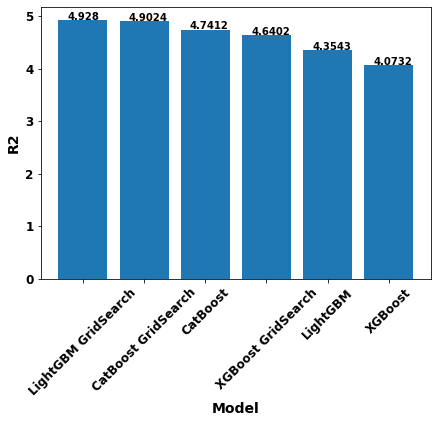

In [ ]:
scores = [round(score, 4) for score in scores]
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R2': scores })
model_scores.sort_values(by='R2',ascending=False,inplace=True)
plot_metric(model_scores, score='R2')

### Training and Prediction Times

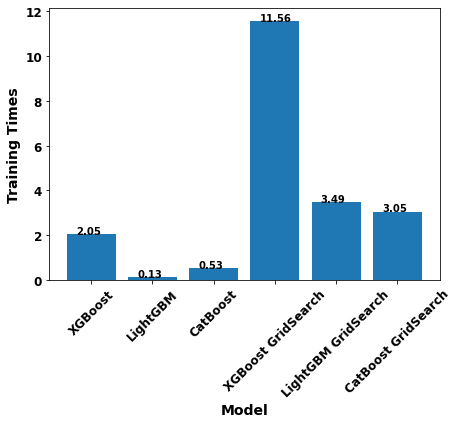

In [ ]:
training_times = [round(time, 2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

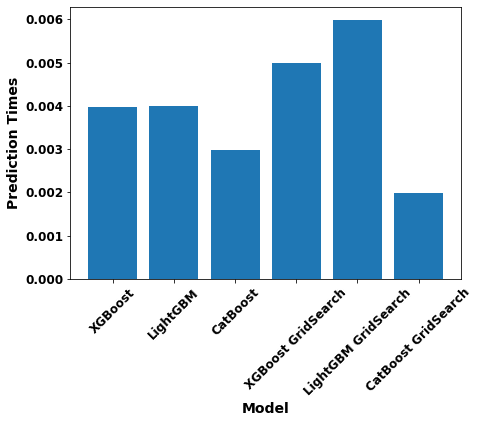

In [ ]:
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Interpretability

A model's prediction score only paints a partial picture of its predictions. We also want to know *why* the model is making its predictions.

Here we plot the model's feature importances, SHAP values and draw an actual decision tree to get a firmer understanding of the model's predictions.

#### Feature Importances

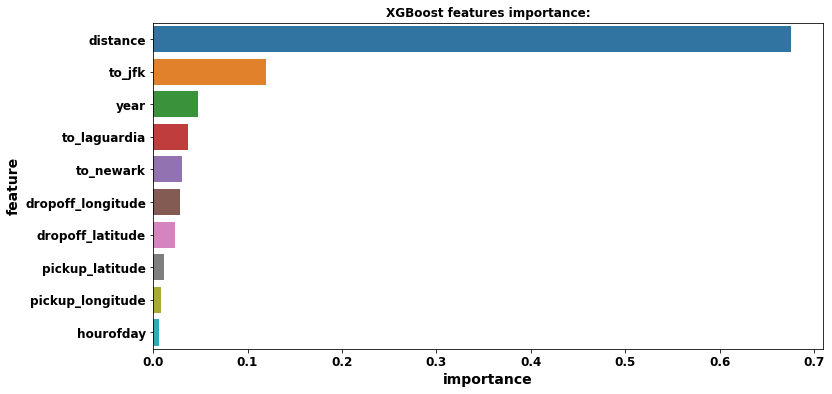

In [ ]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

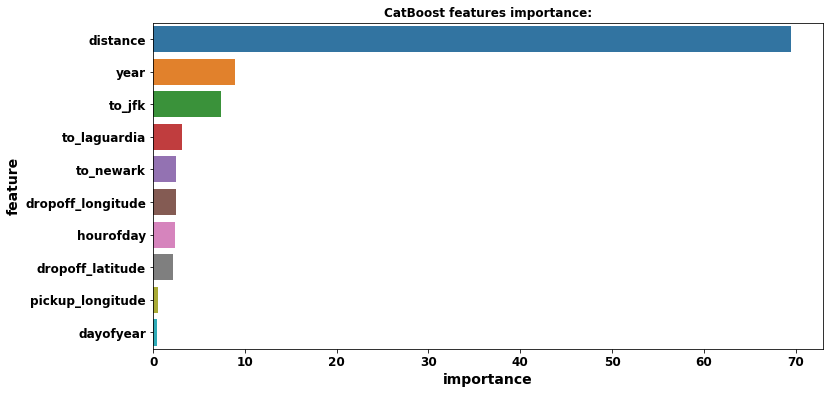

In [ ]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

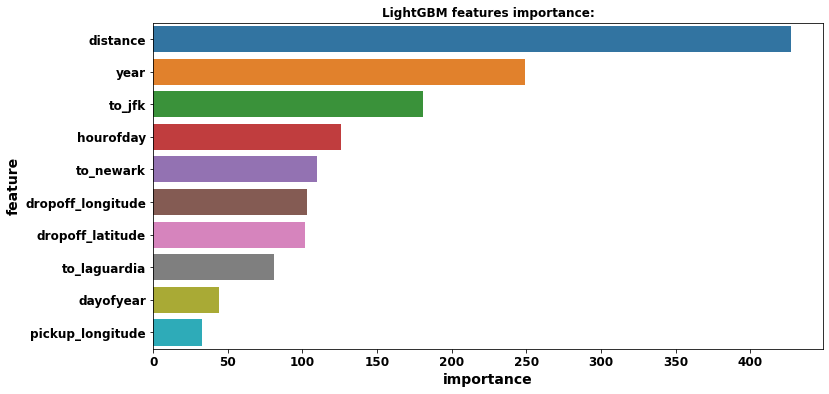

In [ ]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

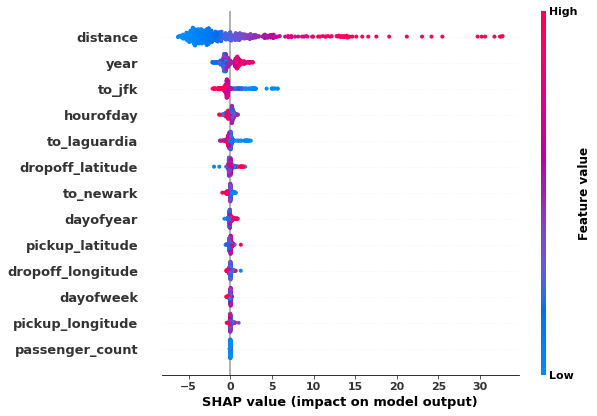

In [ ]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

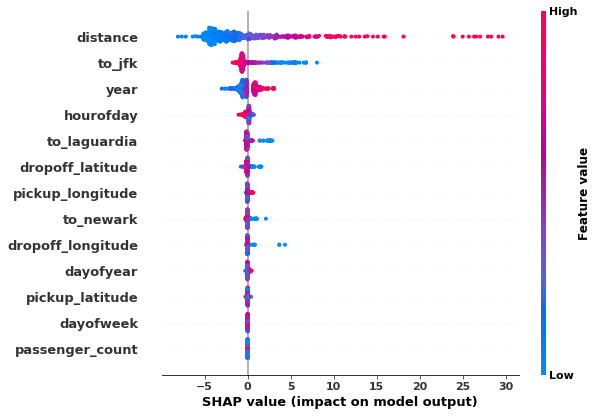

In [ ]:
# CatBoost
shap_values(X_train.iloc[:500,:], cat, 'CatBoost')

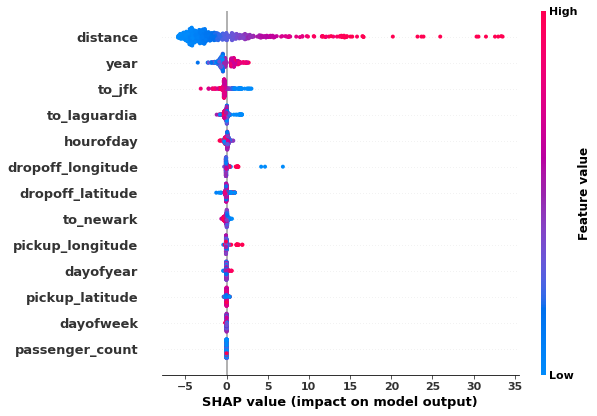

In [ ]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

#### Visualize Trees

In [ ]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

<AxesSubplot:>

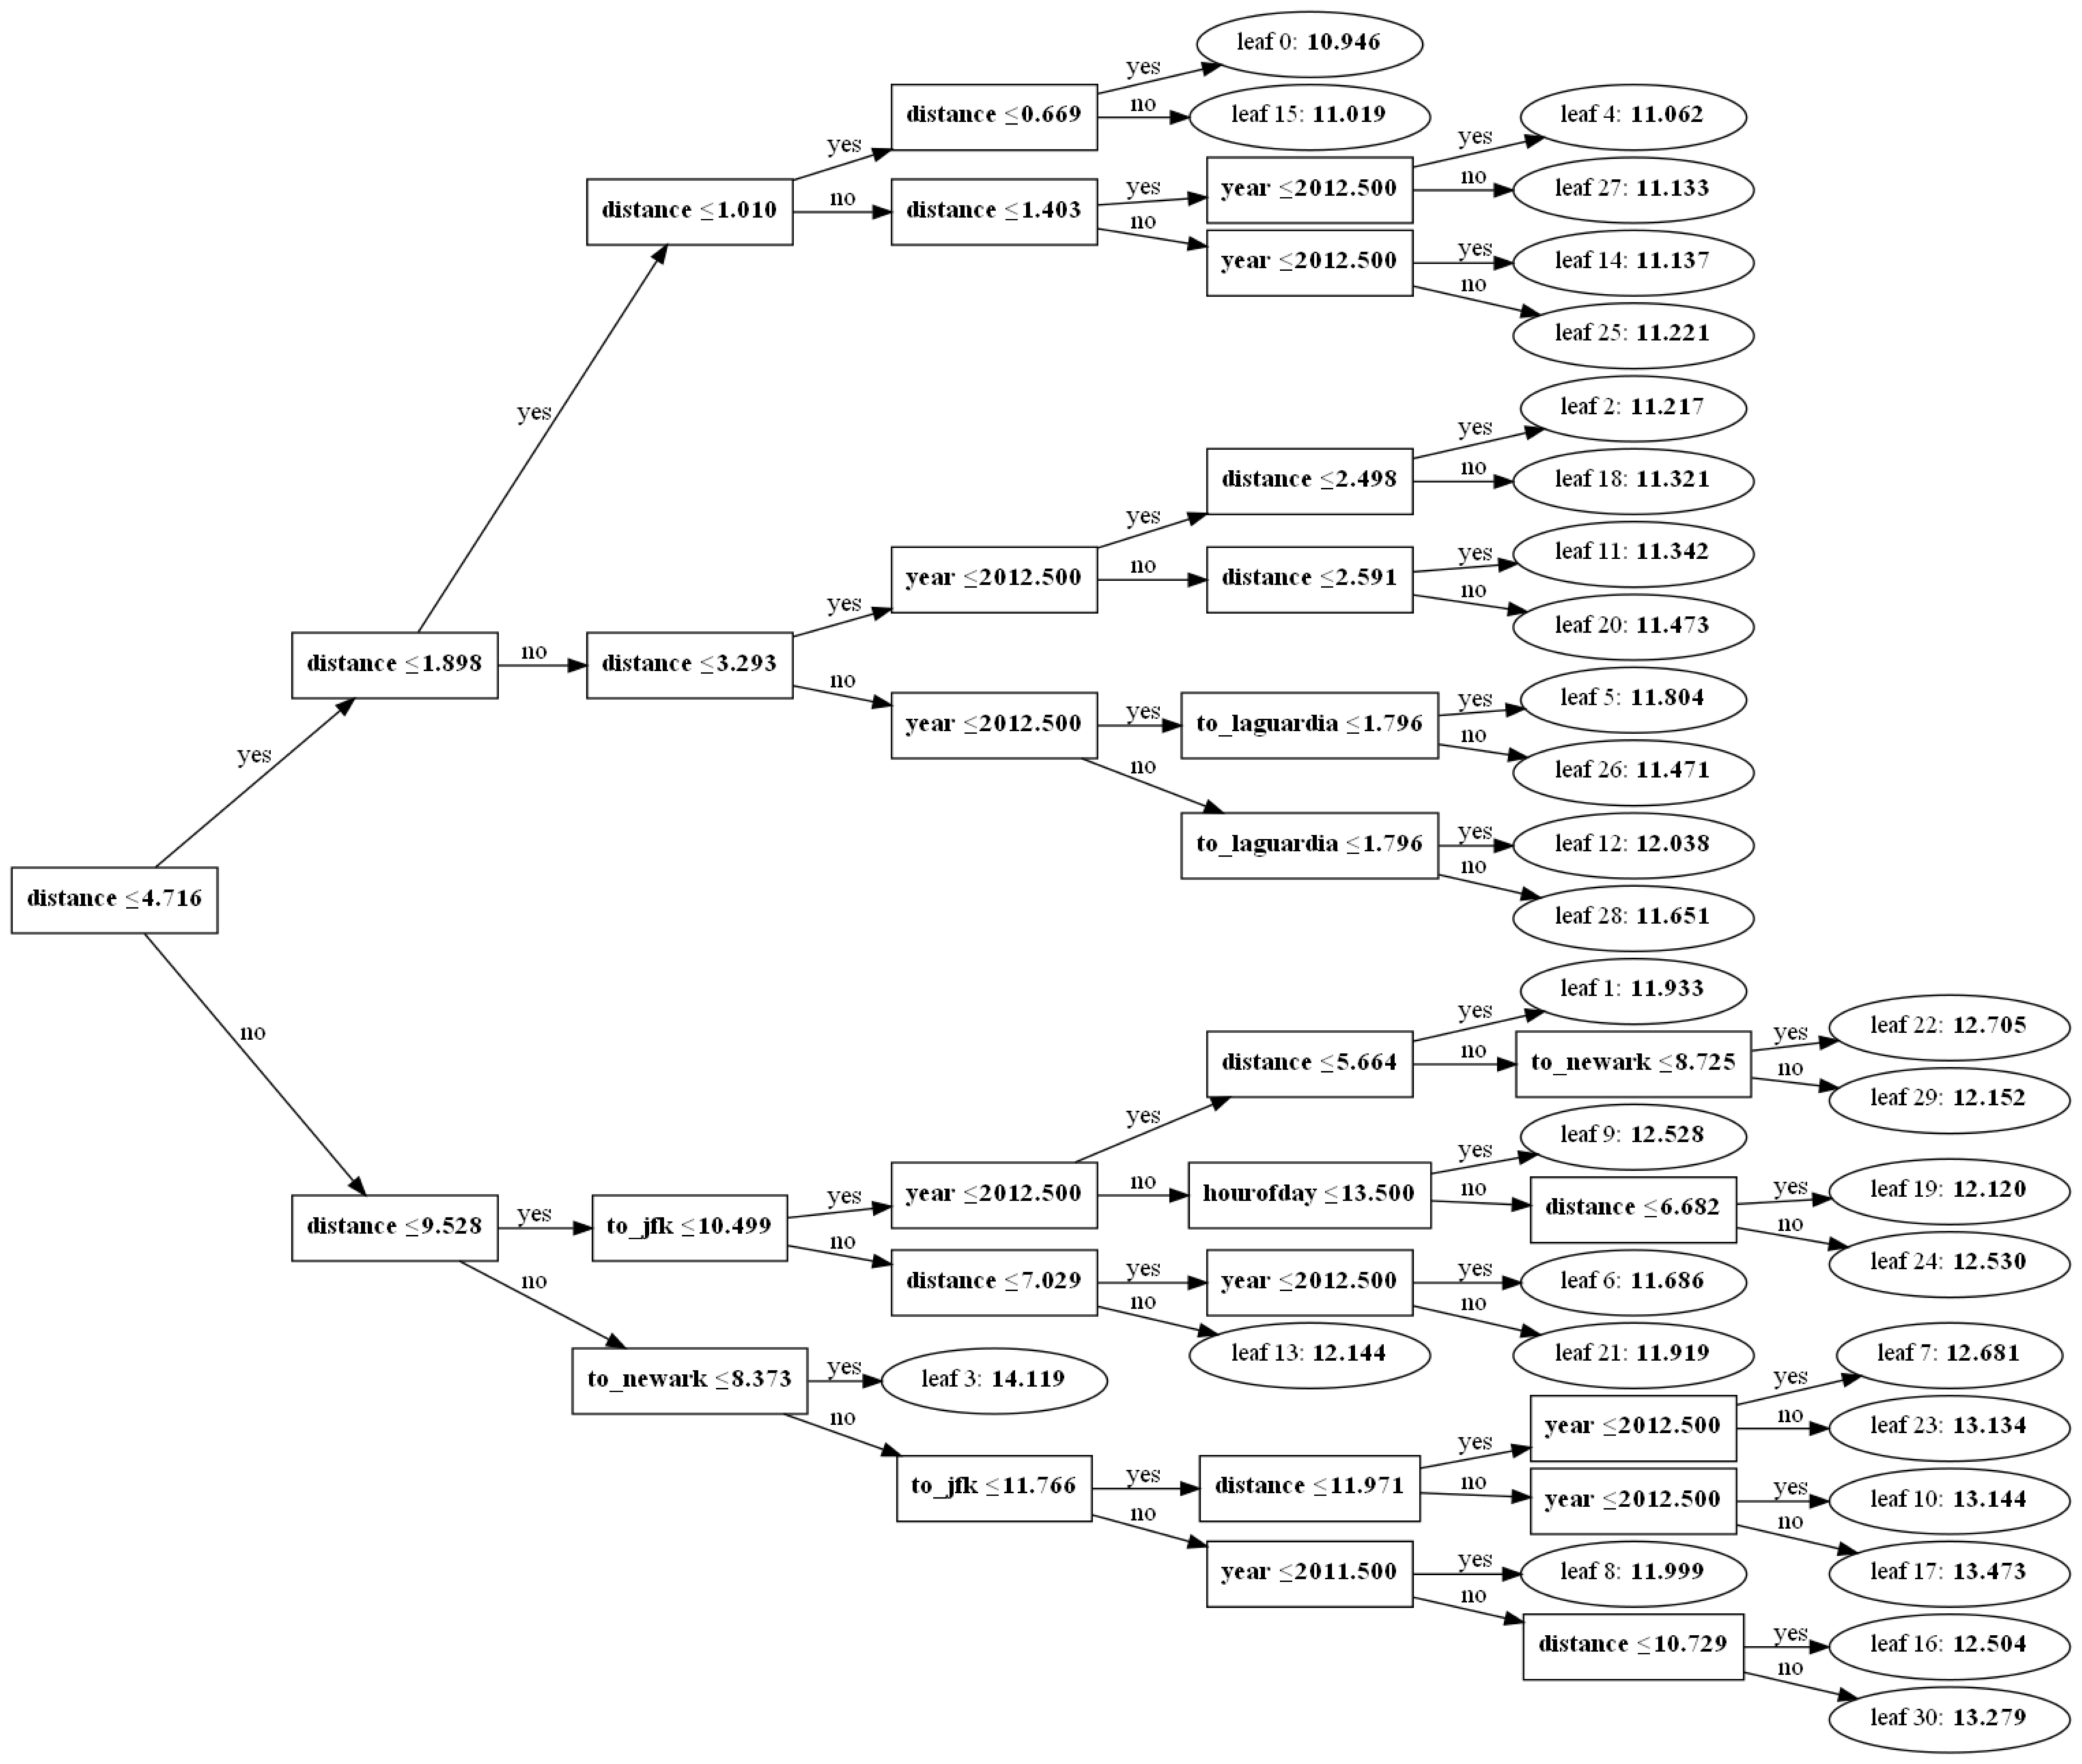

In [ ]:
# LightGBM
lightgbm.plot_tree(lgb)

<AxesSubplot:>

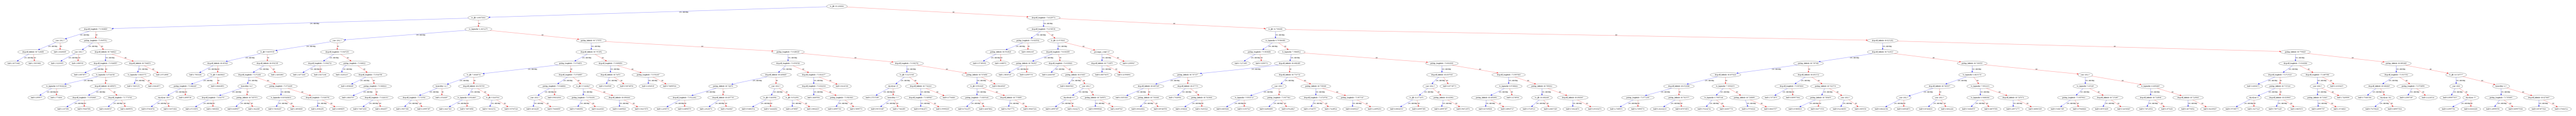

In [ ]:
# XGBoost
xgb.plot_tree(xgboost)

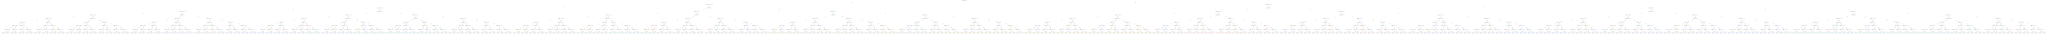

In [ ]:
# CatBoost
cat.plot_tree(0)

In [ ]:
# Clear memory before moving onto the next round
import gc
gc.collect()

9204

# Round 3: Regression on a massive Dataset: Predict NYC Taxi fares (2 million rows, 7 features)

## NYC Taxi dataset (2 million rows, 6 features)

We're using the same dataset as above, but this time instead of training on 60,000 rows, we're going to train the models on 2 million rows and see if they're up to the challenge!

### Feature
- pickup_datetime - timestamp，表示計程車載客的起始時間。

- pickup_longitude - float，計程車載客起始位置的經度坐標。

- pickup_latitude - float，計程車載客起始位置的緯度坐標。

- dropoff_longitude - float，計程車載客結束位置的經度坐標。

- dropoff_latitude - float，計程車載客結束位置的緯度坐標。

- passenger_count - integer，表示乘坐計程車的乘客人數。

### Target
- fare_amount - float，計程車費用(美元)。

In [ ]:
# Get data from New York City Taxi Fare Prediction
# allocate 1000 rows for test set, the rest for training set
train = pd.read_csv('./data/nyctaxi/train_big.csv')
test = pd.read_csv('./data/nyctaxi/test_big.csv')
train.head(3)

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2

In [ ]:
train.shape, test.shape

((2000000, 7), (200000, 7))

## A. Baseline models

In [ ]:
prediction_times = []
training_times = []
scores = []

In [ ]:
train = remove_sparse(train)
test = remove_sparse(test)
train = feature_engineering(train)
test = feature_engineering(test)
y_train = train.fare_amount
X_train = train.drop('fare_amount', axis=1)
y_test = test.fare_amount
X_test = test.drop('fare_amount', axis=1)

In [ ]:
X_train.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  year  dayofweek  dayofyear  hourofday  distance  \
0                1  2009          0        166         13  0.639764   
1                1  2010          1          5         11  5.246511   
2                2  2011          2        229         20  0.863167   
3                1  2012          5        112          0  1.737223   
4                1  2010          1         68          2  1.241710   

      to_jfk  to_laguardia  to_newark  
0   5.641042      3.960033  17.501190  
1  13.128071      5.651922   8.479163  
2  13.205934      5.886113  10.521077  
3  12.390673      6.379848  10.309372  
4  12.972516      4.486914  12.130230

In [ ]:
X_test.head()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.998130        40.740360         -74.004150         40.733418   
1        -74.002960        40.739107         -73.990593         40.746082   
2        -73.985075        40.754526         -74.007655         40.746556   
3        -73.991698        40.759568         -73.996223         40.753263   
4        -73.991271        40.750273         -73.954231         40.770220   

   passenger_count  year  dayofweek  dayofyear  hourofday  distance  \
0                2  2010          2         48         23  0.573840   
1                2  2012          3        145         11  0.808024   
2                1  2013          1        239          6  1.306309   
3                5  2012          5        322          8  0.495634   
4                3  2013          6         69          8  2.381461   

      to_jfk  to_laguardia  to_newark  
0  13.139567      7.032753   9.463861  
1  13.008234      6.531418   9.654219  
2  13.094860      6.096775   9.621335  
3  13.526801      6.369029  10.359148  
4  12.539307      4.327800  10.511757

### XGBoost

In [ ]:
# XGBoost
xgboost = Train(XGBRegressor(n_estimators=50,
                            max_depth = 9,
                            boosting_type = 'gbdt',
                            learning_rate = 0.05,
                            subsample = 0.85,
                            colsample_bytree = 0.8,
                            reg_alpha = 1e-4,
                            silent = True,
                            n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

[10:37:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "boosting_type", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Training time: 
Execution Time: 00:01:16

Prediction time: 
Execution Time: 00:00:00


### LightGBM

In [ ]:
# LightGBM
lgb = Train(LGBMRegressor(n_estimators=50,
                    max_depth = 9,
                    boosting_type = 'gbdt',
                    learning_rate = 0.05,
                    subsample = 0.85,
                    colsample_bytree = 0.8,
                    reg_alpha = 1e-4,
                    silent = True,
                    n_jobs = -1), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:03

Prediction time: 
Execution Time: 00:00:00


### CatBoost

In [ ]:
# Catboost
cat = Train(CatBoostRegressor(n_estimators=50,
                        max_depth = 9,
                        loss_function = 'RMSE',
                        eval_metric = 'RMSE',
                        boosting_type = 'Plain',
                        bootstrap_type = 'Bernoulli',
                        learning_rate = 0.05,
                        subsample = 0.85,
                        silent = True), X_train, y_train, X_test, y_test, type='reg')

Training time: 
Execution Time: 00:00:07

Prediction time: 
Execution Time: 00:00:00


## B. The Results

In [ ]:
models = [('XGBoost', xgboost),
         ('LightGBM', lgb),
         ('CatBoost', cat)]

### RMSE Scores

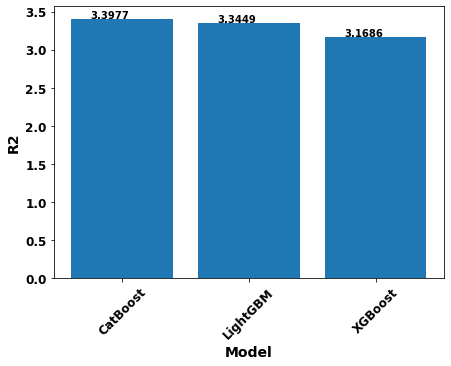

In [ ]:
scores = [round(score, 4) for score in scores]
model_scores = pd.DataFrame({ 'Model': [name for name, _ in models], 'R2': scores })
model_scores.sort_values(by='R2',ascending=False, inplace=True)
plot_metric(model_scores, score='R2')

### Training and Prediction Times

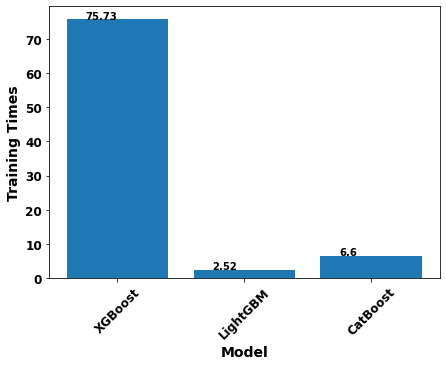

In [ ]:
training_times = [round(time,2) for time in training_times]
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Training Times': training_times })
plot_metric(model_train_times, score='Training Times')

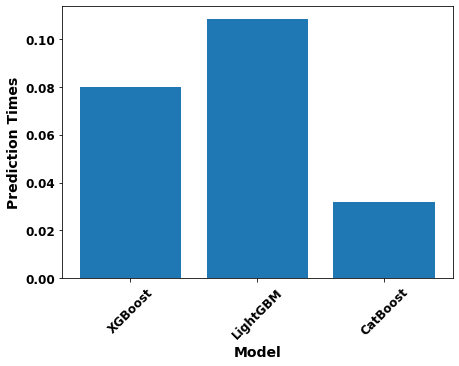

In [ ]:
model_train_times = pd.DataFrame({ 'Model': [name for name, _ in models], 'Prediction Times': prediction_times })
plot_metric(model_train_times, score='Prediction Times')

### Feature Importances

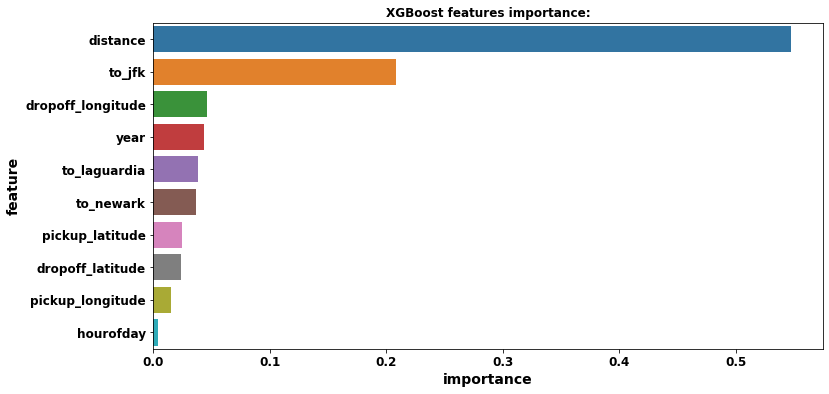

In [ ]:
# XGBoost
feature_importances(X_train, xgboost, 'XGBoost')

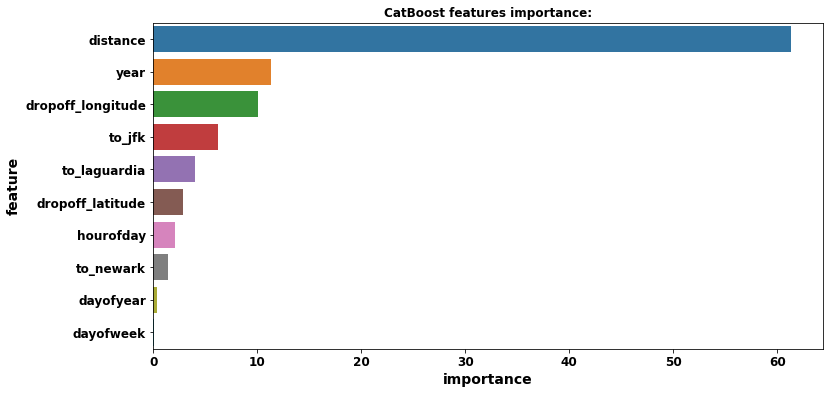

In [ ]:
# CatBoost
feature_importances(X_train, cat, 'CatBoost')

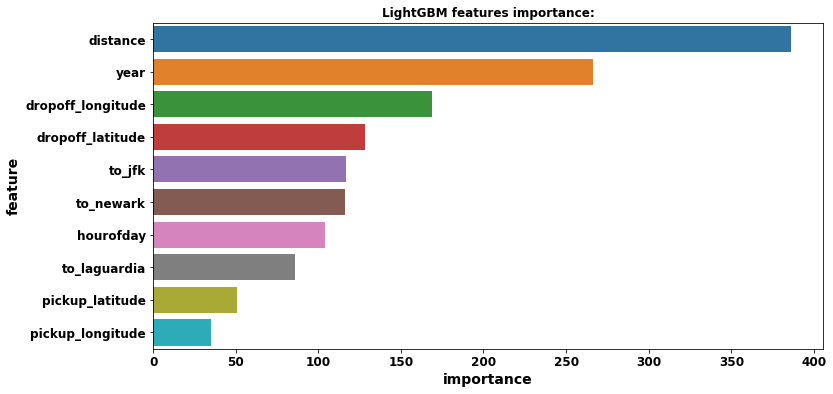

In [ ]:
# LightGBM
feature_importances(X_train, lgb, 'LightGBM')

#### SHAP Values

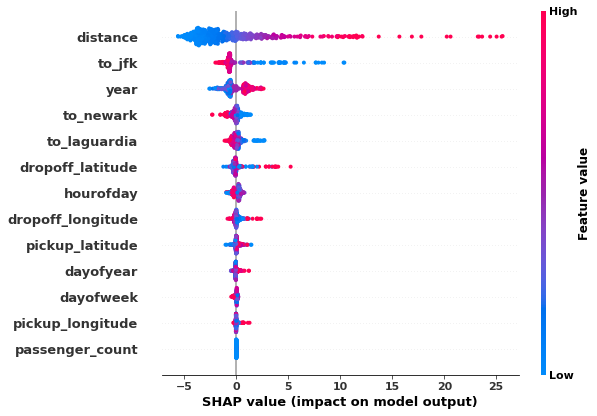

In [ ]:
# XGBoost
shap_values(X_train.iloc[:500,:], xgboost, 'XGBoost')

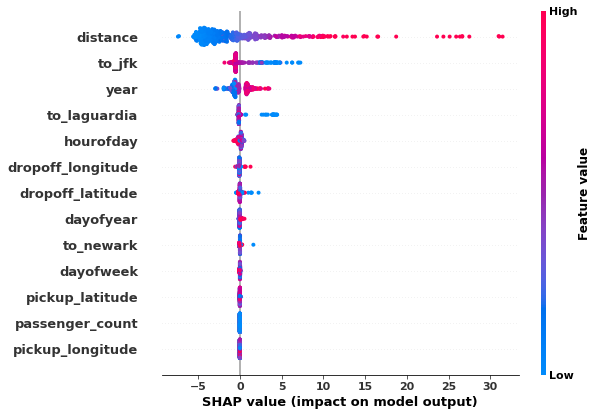

In [ ]:
# CatBoost
shap_values(X_train.iloc[:500,:], cat, 'CatBoost')

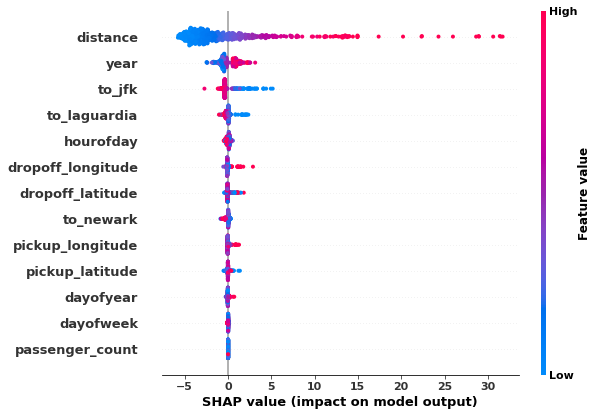

In [ ]:
# LightGBM
shap_values(X_train.iloc[:500,:], lgb, 'LightGBM')

#### Visualize Trees

In [ ]:
# Set figure size for decision tree plots
rcParams['figure.figsize'] = 80,50

<AxesSubplot:>

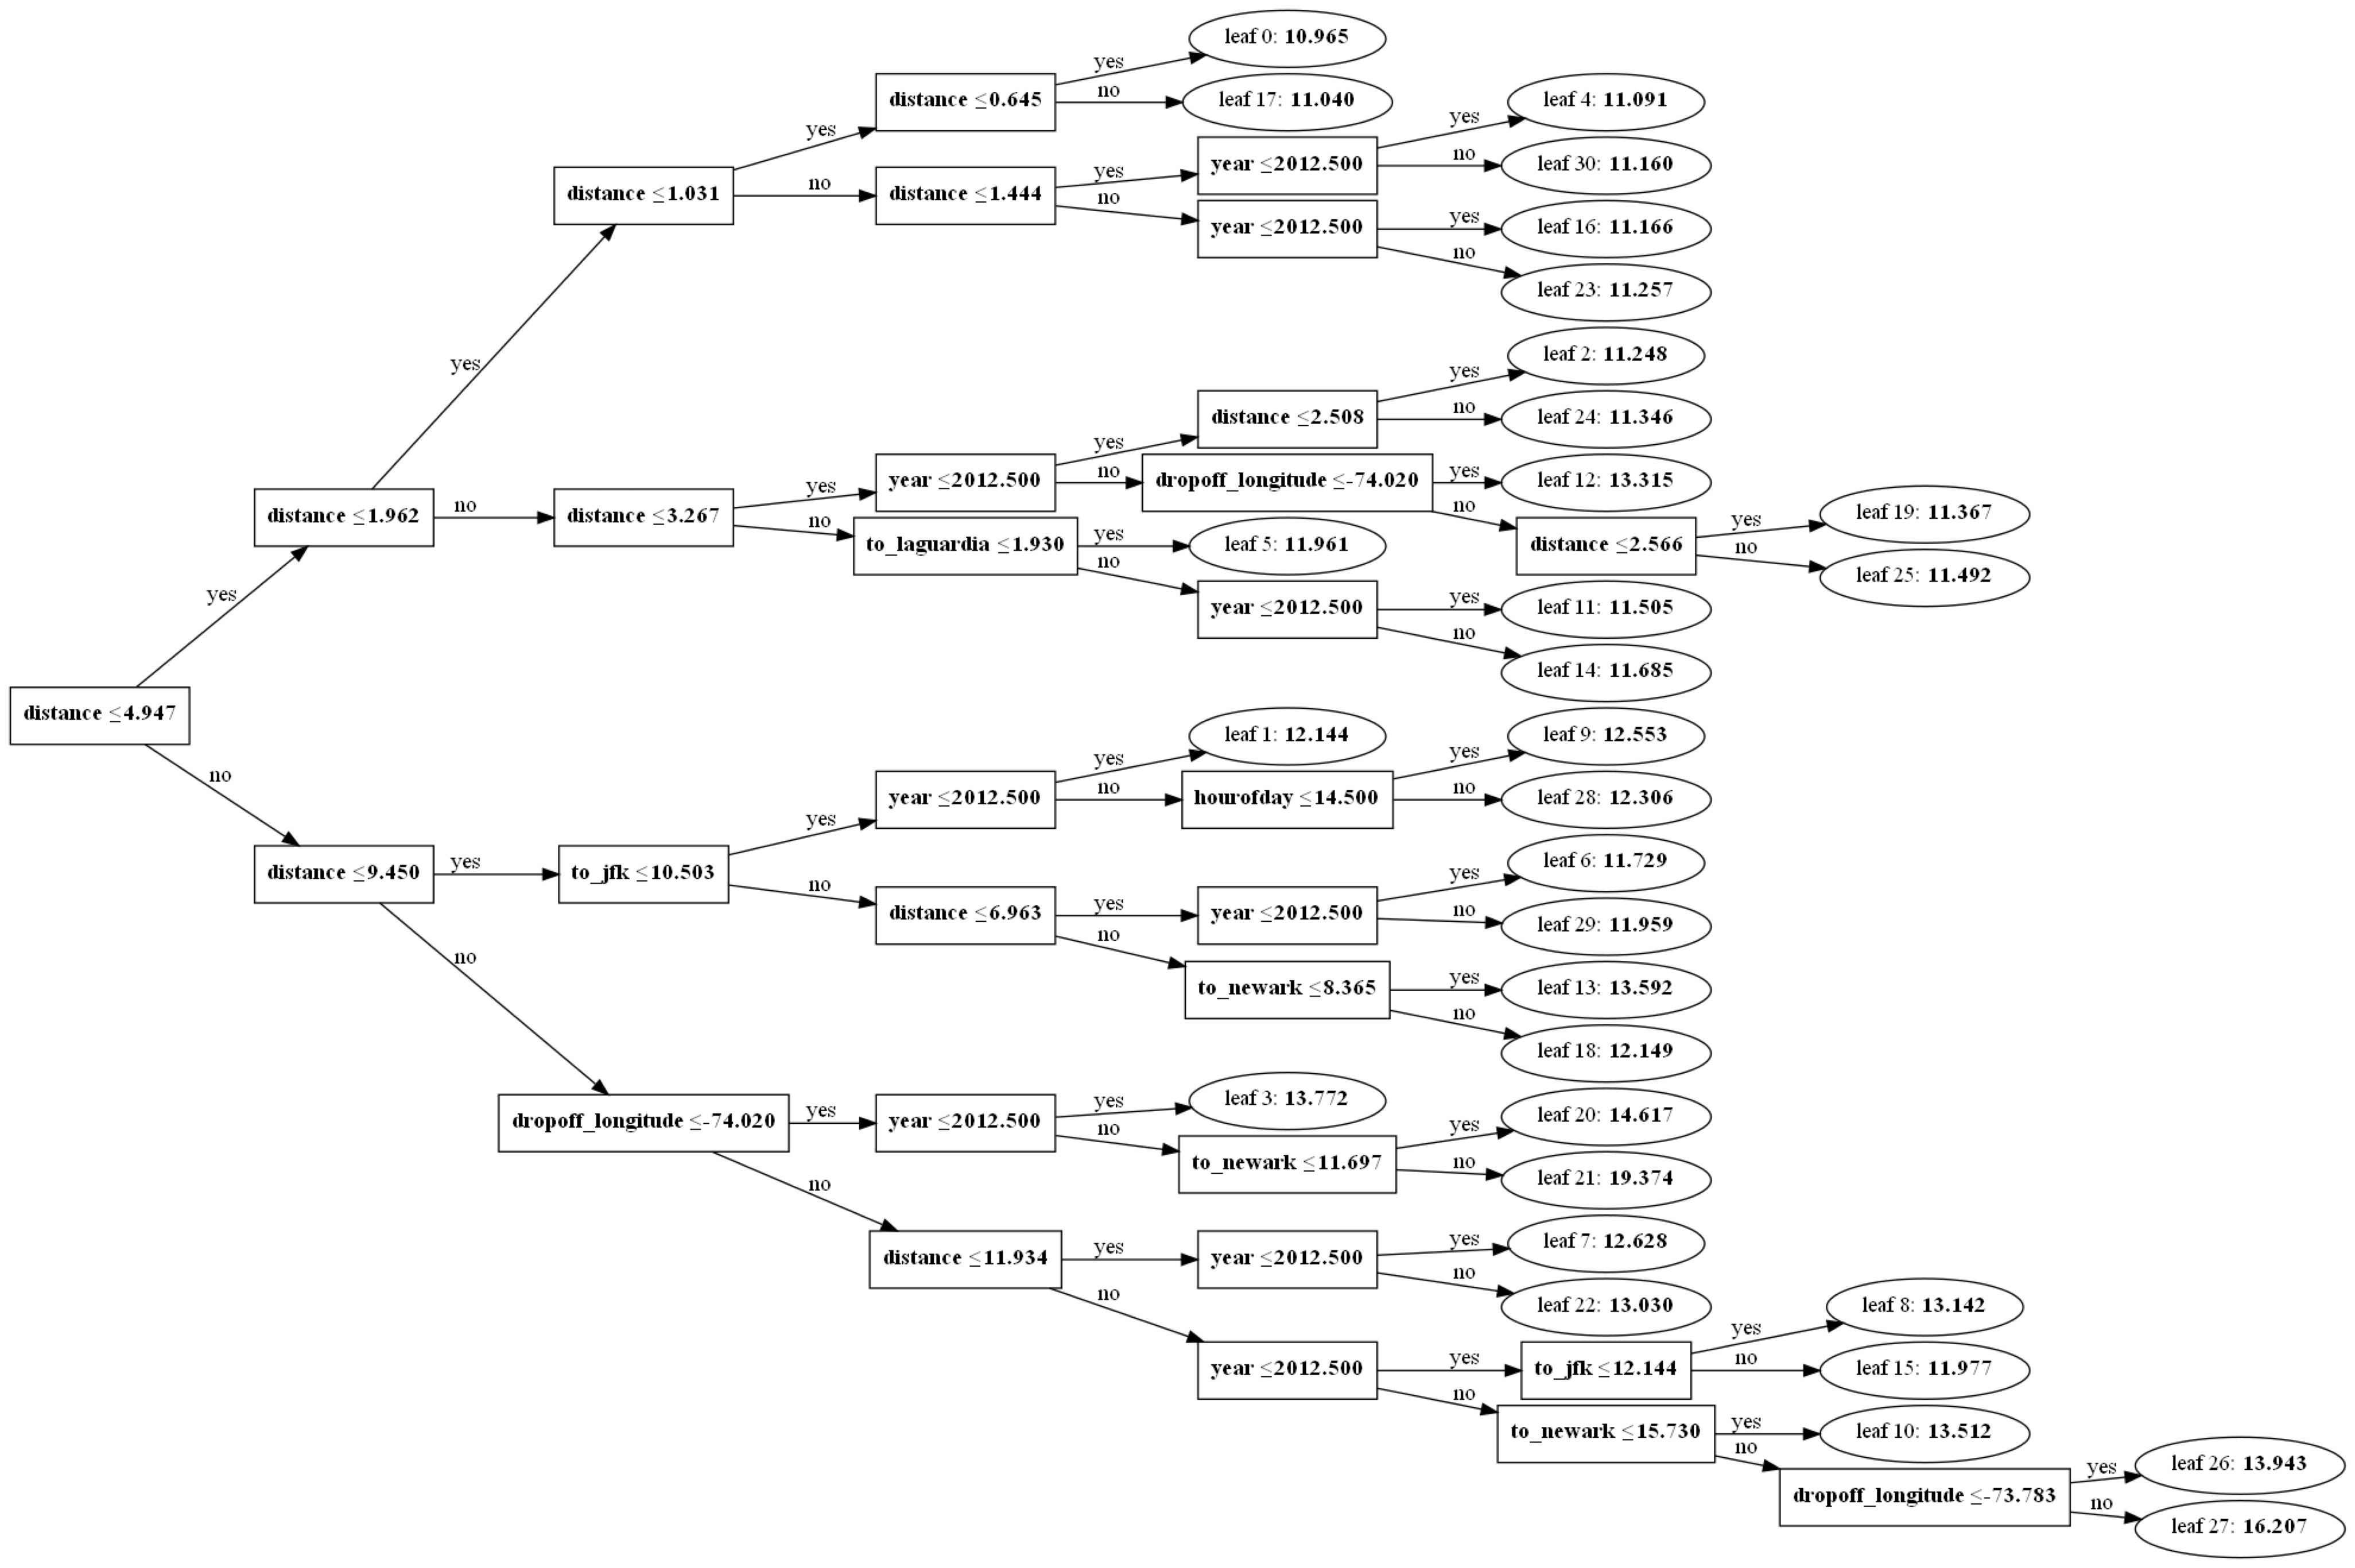

In [ ]:
# LightGBM
lightgbm.plot_tree(lgb)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.479688 to fit


<AxesSubplot:>

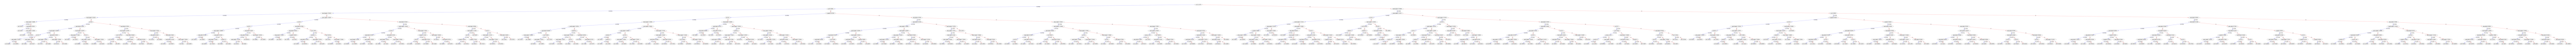

In [ ]:
# XGBoost
xgb.plot_tree(xgboost)

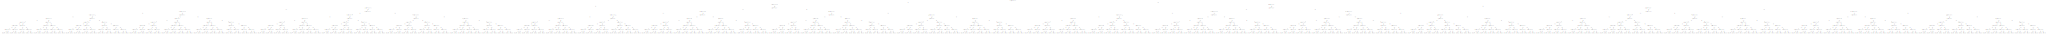

In [ ]:
cat.plot_tree(0)

In [ ]:
# Clear memory before moving onto the next round
import gc
gc.collect()

5

# Model comparison
## Training times:
XGBoost > CatBoost > LightGBM

## Prediction times:
LightGBM > CatBoost >= XGBoost

## Performance:
XGBoost > LightGBM > CatBoost

## CatBoost
- 提供比 XGBoost 更好的訓練時間
- 支持輸入分類特徵(categorical feature)，因此我們不需要預處理分類特徵（例如通過 LabelEncoding 或 OneHotEncoding 它們）。
- 擅長處理 Overfitting，特別是通過實施有序提升(ordered boosting)來處理小型數據集。
- 提供遺失值得處理。

## LightGBM
- 提供比 XGBoost 顯著的訓練時間
- 支持並行樹提升(parallel tree boosting)，即使在大型數據集上也能提供更好的訓練速度。
- 通過使用直方圖式算法(histogram-esque algorithm)將連續特徵分成離散特徵，實現極快的訓練速度和更低的記憶體使用量。

## XGBoost
- 支持並行樹提升(parallel tree boosting)。
- 支持用戶定義的評估指標(evaluation metrics)。
- 提供遺失值得處理。

# Reference
- ### https://lavanya.ai/2019/06/27/battle-of-the-boosting-algorithms/
- ### https://www.kaggle.com/lavanyashukla01/battle-of-the-boosting-algos-lgb-xgb-catboost/notebook